In [1]:
from imports import *
import Utils

import scipy

try:
    %load_ext autoreload
    %autoreload 2
except:
    pass

C:\ProgramData\Miniconda3\envs\keras\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Read and Reshape Data

#### Training Data

In [2]:
# read data
try:
    images, binary_masks, contours_masks, colored_masks = Utils.read_all_training_data()
except:
    path = "input/stage1_train/"
    images, binary_masks, contours_masks, colored_masks = Utils.create_all_data(path, use_masks=True)
    
    filepath = "pickles/train_images.p"
    pickle.dump(images, open(filepath, "wb"))

    filepath = "pickles/train_binary_masks.p"
    pickle.dump(binary_masks, open(filepath, "wb"))

    filepath = "pickles/train_contours_masks.p"
    pickle.dump(contours_masks, open(filepath, "wb"))

    filepath = "pickles/train_colored_masks.p"
    pickle.dump(colored_masks, open(filepath, "wb"))

In [8]:
# reshape data
images, shapes_orig = Utils.reshape_all_images_and_save_orig_shapes(images, new_size=(256, 256))
binary_masks, binary_shapes_orig = Utils.reshape_all_images_and_save_orig_shapes(binary_masks, new_size=(256, 256))
contours_masks, _ = Utils.reshape_all_images_and_save_orig_shapes(contours_masks, new_size=(256, 256))
colored_masks, _ = Utils.reshape_all_images_and_save_orig_shapes(colored_masks, new_size=(256, 256))

In [10]:
# verify new shapes
_ = Utils.get_all_data_shapes(images, verbose=1)
_ = Utils.get_all_data_shapes(binary_masks, verbose=1)

(256, 256, 3)    664
dtype: int64
(256, 256)    664
dtype: int64


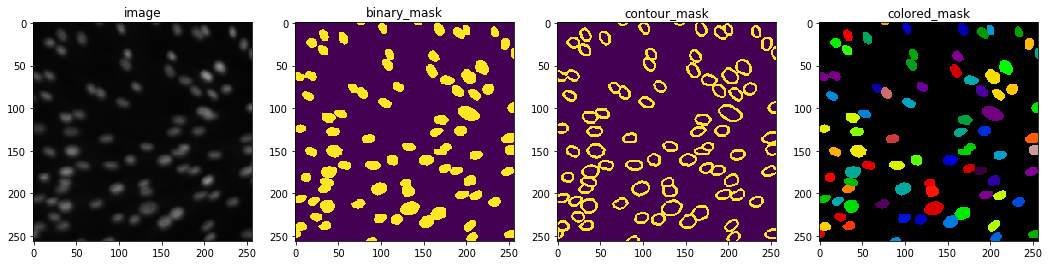

In [11]:
# plot example
i = 12
Utils.plot_list_of_images_in_a_row([images[i], binary_masks[i], contours_masks[i], colored_masks[i]], 
                                 ["image", "binary_mask", "contour_mask", "colored_mask"])

In [25]:
# split train/test
idx_train, idx_test, _, _ = train_test_split(np.arange(len(images)), np.arange(len(images)), test_size=0.1, random_state=42)
idx_train, idx_val, _, _ = train_test_split(np.arange(len(idx_train)), np.arange(len(idx_train)), test_size=0.1, random_state=42)

images_train = images[idx_train]
images_test = images[idx_test]
images_val = images[idx_val]

binary_masks_train = binary_masks[idx_train]
binary_masks_test = binary_masks[idx_test]
binary_masks_val = binary_masks[idx_val]


contours_masks_train = contours_masks[idx_train]
contours_masks_test = contours_masks[idx_test]
contours_masks_val = contours_masks[idx_val]


colored_masks_train = colored_masks[idx_train]
colored_masks_test = colored_masks[idx_test]
colored_masks_val = colored_masks[idx_val]

### Create Image Generators

In [30]:
data_gen_args_img = dict(samplewise_center=True,
                     samplewise_std_normalization=True,
                     rotation_range=90.,
                     width_shift_range=0.2,
                     height_shift_range=0.2,
                     zoom_range=0.2, 
                     fill_mode="reflect")

data_gen_args_msk = dict(rotation_range=90.,
                     width_shift_range=0.2,
                     height_shift_range=0.2,
                     zoom_range=0.2, 
                     fill_mode="reflect")


def create_generators_pair(X, Y, seed=0):
    image_datagen = ImageDataGenerator(**data_gen_args_img)
    mask_datagen = ImageDataGenerator(**data_gen_args_msk)
    
    image_datagen.fit(X, augment=True, seed=seed)
    mask_datagen.fit(Y, augment=True, seed=seed)

    image_generator = image_datagen.flow(X, seed=seed, batch_size=BATCH_SIZE, shuffle=True)
    mask_generator = mask_datagen.flow(Y, seed=seed, batch_size=BATCH_SIZE, shuffle=True)

    # combine generators into one which yields image and masks
    train_generator = zip(image_generator, mask_generator)

    return image_generator, mask_generator, train_generator

#### generator for masks-model

In [31]:
image_generator_train1, mask_generator_train1, generator_train1 = create_generators_pair(images_train, binary_masks_train)
image_generator_val1, mask_generator_val1, generator_val1 = create_generators_pair(images_val, binary_masks_val)

ValueError: Input to `.fit()` should have rank 4. Got array with shape: (537, 256, 256)

In [ ]:
# compare generators...

#### generator for contours-model

In [ ]:
image_generator_train2, mask_generator_train2, generator_train2 = create_generators_pair(images_train, contours_masks_train)
image_generator_val2, mask_generator_val2, generator_val2 = create_generators_pair(images_val, contours_masks_val)

In [ ]:
# compare generators...

### Train Models:

In [ ]:
UNET_DEPTH = 6
UNET_INIT_FILTERS = 16

BATCH_SIZE = 8
LR_INIT = 1e-3
LR_MIN = 1e-9

#### Masks Model

In [ ]:
unet = myUnetHP()
model_masks = unet.build(n_depth_layers=UNET_DEPTH, n_init_filters=UNET_INIT_FILTERS, x_max=1.)

In [ ]:
# Compile model:
model_masks.compile(optimizer=Adam(lr = LR_INIT), loss='binary_crossentropy', metrics=[mean_iou])

In [ ]:
checkpointer = ModelCheckpoint('model_masks-nuclei2018-1.h5', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=30, min_lr=LR_MIN, verbose=1) # search "learning rate"

In [ ]:
# model_weights_path = "model-nuclei2018-2-dph%d_flts%d.h5"%(UNET_DEPTH, UNET_INIT_FILTERS)
model_weights_path = "model_masks-nuclei2018-1.h5"
# model_weights_path = "model-nuclei2018-3-dph%d_flts%d_epochs30000.h5"%(UNET_DEPTH, UNET_INIT_FILTERS)
# if os.path.isfile(model_weights_path):
#     model.load_weights("model_weights_path")

In [ ]:
results = model_masks.fit_generator(generator_train, epochs=10000, validation_data=generator_val, callbacks=[checkpointer, reduce_lr],
                              steps_per_epoch=X_train.shape[0]//BATCH_SIZE, 
                              validation_steps=X_val.shape[0]//BATCH_SIZE, 
                              verbose=1)

#### Contours Model

In [ ]:
unet = myUnetHP()
model_contours = unet.build(n_depth_layers=UNET_DEPTH, n_init_filters=UNET_INIT_FILTERS, x_max=1.)

In [ ]:
# Compile model:
model_contours.compile(optimizer=Adam(lr = LR_INIT), loss='binary_crossentropy', metrics=[mean_iou])

In [ ]:
checkpointer = ModelCheckpoint('model_contours-nuclei2018-1.h5', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=30, min_lr=LR_MIN, verbose=1) # search "learning rate"

In [ ]:
# model_weights_path = "model-nuclei2018-2-dph%d_flts%d.h5"%(UNET_DEPTH, UNET_INIT_FILTERS)
model_weights_path = "model_contours-nuclei2018-1.h5"
# model_weights_path = "model-nuclei2018-3-dph%d_flts%d_epochs30000.h5"%(UNET_DEPTH, UNET_INIT_FILTERS)
# if os.path.isfile(model_weights_path):
#     model.load_weights("model_weights_path")

In [ ]:
results = model_contours.fit_generator(generator_train, epochs=10000, validation_data=generator_val, callbacks=[checkpointer, reduce_lr],
                              steps_per_epoch=X_train.shape[0]//BATCH_SIZE, 
                              validation_steps=X_val.shape[0]//BATCH_SIZE, 
                              verbose=1)

### Post-Processing (Masks+Contours)

### Evaluate Performance

### Prepare Submission

#### binary-mask to multiple masks

In [33]:
# for-loop over: Utils.from_binary_mask_to_masks(mask)